In [6]:
import cv2
import numpy as np
import tempfile
import requests
import matplotlib.pyplot as plt 
from PIL import Image
import aiohttp
import asyncio
from dataclasses import dataclass


@dataclass
class ModelResults:
    image: np.ndarray
    xyxy_points: list | None = None
    

In [7]:
def detect_cars(image: np.ndarray, endpoint_url: str) -> list:
    _, img_encoded = cv2.imencode(".jpg", image)
    image_bytes = img_encoded.tobytes()
    files = {"file": image_bytes}
    response = requests.post(endpoint_url, files=files)
    assert response.ok, "Failed to detect image..."
    response = response.json()
    return response


In [8]:
def draw_bbox(xyxy_points: list, image):
    for xyxy in xyxy_points:
        p1, p2 = (int(xyxy[0]), int(xyxy[1])), (int(xyxy[2]), int(xyxy[3]))
        image = cv2.rectangle(image, p1, p2, (255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
    return image

In [9]:


def get_frames(filename = "../assets/RoadTraffic.mp4") -> list[np.ndarray]:
    # with tempfile.NamedTemporaryFile(delete=False) as temp_file:
    #     temp_file.write(video_file.read())
    # cap = cv2.VideoCapture(temp_file.name)
    
    cap = cv2.VideoCapture(filename)
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_width = int(cap.get(3)) 
    frame_height = int(cap.get(4)) 
    size = (frame_width, frame_height) 
    
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret: break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()

    return frames, fps, size


In [10]:
frames, fps, size = get_frames()

In [62]:
enumerate_frames = dict(list(enumerate(frames)))

In [11]:
import aiohttp
import asyncio

async def get_model_result(session: aiohttp.ClientSession, frames: dict, idx: int, url):
    try:
        image = frames[idx].image
        _, img_encoded = cv2.imencode(".jpg", image)
        image_bytes = img_encoded.tobytes()
        async with session.post(url, data={"file": image_bytes}) as response:
            frames[idx].xyxy_points = response.json()
    except Exception as e:
        print(f"Error uploading image {idx}: {e}")


async def detect_cars(frames: list[np.ndarray], endpoint_url: str):
    frames = {
        i: ModelResults(image=image) for i, image in enumerate(frames)
    }

    async with aiohttp.ClientSession() as session:
        tasks = [
            get_model_result(
                session, frames=frames, idx=idx, url=endpoint_url
            ) 
            for idx in frames.keys()
        ]
        await asyncio.gather(*tasks)


# def detect_cars(image: np.ndarray, endpoint_url: str) -> list:
#     _, img_encoded = cv2.imencode(".jpg", image)
#     image_bytes = img_encoded.tobytes()
#     files = {"file": image_bytes}
#     response = requests.post(endpoint_url, files=files)
#     assert response.ok, "Failed to detect image..."
#     response = response.json()
#     return response


if __name__ == "__main__":
    asyncio.run(detect_cars(frames=frames, endpoint_url="https://dc9b-34-86-144-173.ngrok-free.app?conf=0.1"))

RuntimeError: asyncio.run() cannot be called from a running event loop

In [75]:
image = frames[13]
# image = cv2.imread("../../traffic_signal.jpg")

xywh_points = detect_cars(image, endpoint_url="https://dc9b-34-86-144-173.ngrok-free.app?conf=0.1")
image = draw_bbox(xywh_points, image)

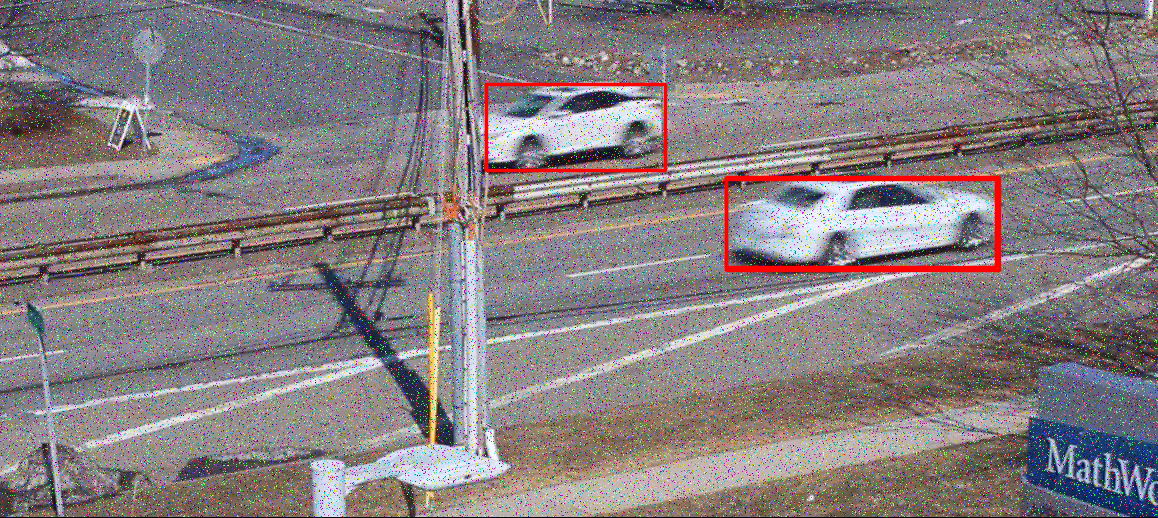

In [76]:
Image.fromarray(image)